### Storm Simulation- Alexauken Creek Watershed
Gabriela Birardi  
Spring 2023  
Senior Thesis Project  
Advisor: Frank Pazzaglia  

In [38]:
## only needed for plotting in a jupyter notebook.
%matplotlib inline


# PYTHON IMPORTS
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel
import cv2 
from random import randint
import math

# LANDLAB COMPONENTS 
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow
from landlab.components import PrecipitationDistribution

# SPACE COMPONENTS 
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

# LANDLAB UTILITIES 
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 
from landlab.utils.flow__distance import calculate_flow__distance

%matplotlib inline

### SETTING UP THE MODEL GRID

In [39]:
# Change the flags to choose the intensity of the storm and on which type of topgraphy it is being run on 
basin_flag = "IncrInt"  # "IncrInt" for a increased rainfall topography or "BaseInt" for the basefall level topography
storm_flag = "50Year"  # " 10Year" for 10-year reccurent storm or "50Year" for 50-year recurrant storm

## Node locations for alexauken
outlet = 1770
midstream = 2872
upstream = 3885

# Now based on the flag the correct topography will be imported 
if basin_flag == "BaseInt":
    # the watershed_dem can be changes to the alexauken or the synthetic topography-- right now it is set up for the alexauken creek watershed
    watershed_dem = "alex_reg_int_topo.txt" #file name and location of the ascii file to be read in containing topography values
    (rmg, z) = read_esri_ascii(watershed_dem, name="topographic__elevation")
    #setting up the locations with the Node ID number for the outlet, midstream and upstream locations
    outlet_node_to_sample = 1770 
    outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    print(outlet_link_to_sample)
    upstream_node_to_sample = 3885 
    upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
    print(upstream_link_to_sample)
    midstream_node_to_sample = 2872 
    midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][3]
    print(midstream_link_to_sample)
else:
    watershed_dem = "alex_increasing_int_topo.txt"  #file name and location of the ascii file to be read in containing topography values
    #setting up the locations with the Node ID number for the outlet, midstream and upstream locations
    (rmg, z) = read_esri_ascii(watershed_dem, name="topographic__elevation")
    outlet_node_to_sample = 1770 
    outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    print(outlet_link_to_sample)
    upstream_node_to_sample = 3885 
    upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
    print(upstream_link_to_sample)
    midstream_node_to_sample = 2872 
    midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][3]
    print(midstream_link_to_sample)
    
### RUN FLOW ROUTING 
# This will detect the drainage area and chanel
fr = FlowAccumulator(rmg)  # Instantiate flow router
fr.run_one_step()

3429
7619
5610


### SETTING UP STORM INTENSITY AND DURATION

In [41]:
rmg.set_watershed_boundary_condition(z) #set up boundary around the model grid

# instantiate OverlandFlow component
rmg.add_zeros("surface_water__depth", at="node")
of = OverlandFlow(rmg, alpha=0.45, steep_slopes=True)

#Based on the flag chose the depth and intensity of the hurricane event. Duration of storm does not change and is 24 hrs long
if storm_flag == "10Year":
    starting_precip_mmhr = 5.0
    starting_precip_ms = 0.000001469 
    storm_duration = 86400
elif storm_flag == "50Year":
    starting_precip_mmhr = 5.29
    starting_precip_ms = 0.00000225483 # 0.194818 m over 24 hr
    storm_duration = 86400 
    

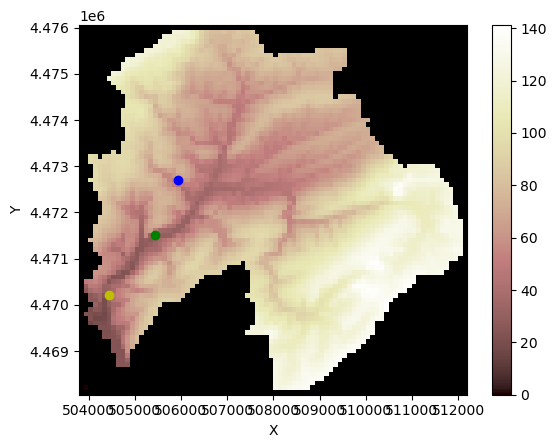

In [42]:
# PLOT THE LOCATIONS OF OUTLET, UPSTREAM AND MIDSTREAM
plt.figure(1)
imshow_grid(rmg, z)  # plot the DEM
plt.plot(rmg.node_x[outlet_node_to_sample], rmg.node_y[outlet_node_to_sample], "yo")
plt.plot(rmg.node_x[upstream_node_to_sample], rmg.node_y[upstream_node_to_sample], "bo")
plt.plot(rmg.node_x[midstream_node_to_sample], rmg.node_y[midstream_node_to_sample], "go")

### SIMULATE THE HURRICANE

In [44]:
# time variables
elapsed_time = 0.0  #(s)
model_run_time = 86400+20000  #(s) - adding 20000 to see after storm 

#variables for info storage
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []
hydrograph_time = []

#set up needed fields
rmg["node"]["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

### LOOP TO RUN IT 
while elapsed_time < model_run_time:
    of.dt = of.calc_time_step() #adaptive time stepping 
    # add rainfall to the model grid only during the duration of the storm 
    if elapsed_time < (storm_duration):
        of.rainfall_intensity = starting_precip_ms
    else:  #no more rainfall 
        of.rainfall_intensity = 0.0

    of.run_one_step()  #generate the overland flow

    #saving time and discharge values 
    q = rmg.at_link["surface_water__discharge"]
    discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * rmg.dx )
    discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * rmg.dx )
    discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * rmg.dx)

    #add to the elapsed time based on the overland flow created timestep
    elapsed_time += of.dt
    

elapsed time =  0.0
elapsed time =  15001.9545366
elapsed time =  22001.3209614
elapsed time =  23000.3669555
elapsed time =  28000.4576541
elapsed time =  39000.32045
elapsed time =  41000.6723679
elapsed time =  46000.0240158
elapsed time =  47001.819486
elapsed time =  51001.3396175
elapsed time =  52000.163557
elapsed time =  55001.0555601
elapsed time =  61000.4456573
elapsed time =  62001.0235287
elapsed time =  63001.5902639
elapsed time =  69001.9316617
elapsed time =  71001.2439454
elapsed time =  72000.0224995
elapsed time =  75001.1536864
elapsed time =  79000.896701
elapsed time =  82001.9670361
elapsed time =  83000.6246452
elapsed time =  86001.7060611
elapsed time =  91000.6944625
elapsed time =  95001.3083081
elapsed time =  96000.9798262
elapsed time =  99001.3566933
elapsed time =  100001.567161
elapsed time =  105000.723195
elapsed time =  106001.885277


### CREATING THE HYDROGRAPHS 

(0.0, 20000.0, 0.0, 0.5)

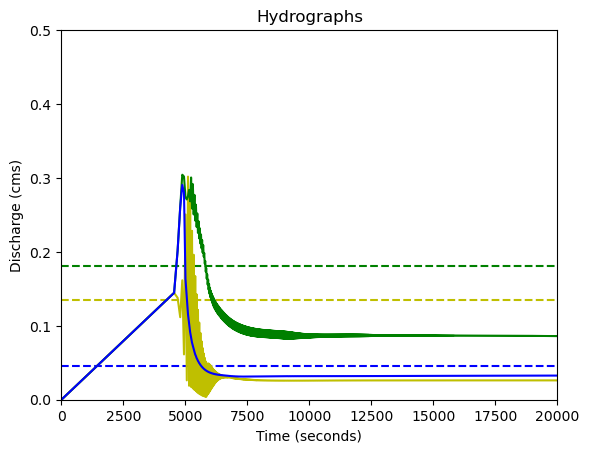

In [45]:
#set up the figure and subplot
plot = plt.figure()
hydro = plt.subplot()

#calculate equilibrium discharges first
outlet_eq_q = starting_precip_ms * rmg.at_node["drainage_area"][outlet_node_to_sample]
midstream_eq_q = (starting_precip_ms * rmg.at_node["drainage_area"][midstream_node_to_sample])
upstream_eq_q = (starting_precip_ms * rmg.at_node["drainage_area"][upstream_node_to_sample])

#now plot those equil discharges
plt.axhline(y=outlet_eq_q, color='y', linestyle='--',label="outlet eq Q")
plt.axhline(y=midstream_eq_q, color='g', linestyle='--',label="midstream eq Q")
plt.axhline(y=upstream_eq_q, color='b', linestyle='--', label="upstream eq Q")

# plot the actual hydrograph lines
hydro.plot(hydrograph_time, discharge_at_outlet, "y-", label="outlet")
hydro.plot(hydrograph_time, discharge_midstream, "g-", label="midstream")
hydro.plot(hydrograph_time, discharge_upstream, "b-", label="upstream")

# plot the end of the storm
hydro.plot([storm_duration, storm_duration], [0, 100], "k-", linewidth=2, label="storm end")

# add labels and formatting 
plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper left")
title_text = "Hydrographs"
plt.title(title_text)
plt.axis([0, 20000, 0, 0.5]) 

In [46]:
fname = "hydrograph_"+ str(basin_flag) +"_"+str(storm_flag)+ ".png"
plt.savefig(fname, dpi='figure', format=None)

<Figure size 640x480 with 0 Axes>